# Import dependencies

`warnings` and `itertools` are built-in, the others will have to be installed with `conda` (Anaconda) or `pip`.

In [1]:
import warnings
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Optional.

The `seaborn` dependency is just for giving the points in the graph a nice colour. It can be omitted if you want to set the colour manually. Just make sure to remove the call to `sns.color_palette()` in the cell at the bottom.

# Load data files

Load data files into two variables:
- `obs_df` containing the observed values (which will need to be averaged)
- `bootstrap_dfs` containing samples from the corresponding null distributions

(The `df` suffix is my shorthand for indicating that a variable is a table; a `DataFrame` in Python- or R-speak.)

If your data is stored in an Excel spreadsheet, you can replace `pd.read_csv` with `pd.read_excel` (documentation [here](https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html)).

In [2]:
obs_df = pd.read_csv('../../interneuron-reward-data/processed/mean_fluo_df.csv')

bootstrap_dfs = {
    ct: pd.read_csv(f'../../interneuron-reward-data/processed/{ct}_corr_bootstrap.csv')
    for ct in ('pyr', 'vip', 'pv', 'som')
}

The cell below shows the format of the `obs_df` table. The values that will be plotted are in the `tone`, `tone + delay`, and `reward` columns.

In [3]:
obs_df.head()

,day,cell_type,cell_id,mouse_id,tone fluo,tone + delay fluo,reward fluo,tone,tone + delay,reward
0,1,vip,3121,CL136,0.006833,-0.006349,-0.015298,-0.042650,-0.089601,-0.110405
1,7,vip,3121,CL136,0.056056,0.292485,0.064681,-0.205642,-0.022913,-0.320235
2,1,vip,3122,CL136,0.078297,0.026572,-0.122830,0.110171,0.048225,-0.311567
3,7,vip,3122,CL136,-0.027618,-0.061786,0.218032,-0.240343,-0.429629,-0.054292
4,1,vip,3123,CL136,-0.002098,0.013350,0.032032,-0.062735,-0.045220,-0.022335


# Compute descriptive statistics

In [4]:
def get_change(obs_df, cell_type: str) -> pd.DataFrame:
    """Get a DataFrame containing the change in relevant measurements from day 1 to day 7."""
    d1 = obs_df.query('(day == 1) and (cell_type == @cell_type)').set_index('cell_id')
    d7 = obs_df.query('(day == 7) and (cell_type == @cell_type)').set_index('cell_id')
    
    # Check that the same cells are in both d1 and d7 (since index was set to `cell_id`).
    # If these don't match, d7['x'] - d1['x'] will introduce NaNs.
    if not np.all(d1.index.to_numpy() == d7.index.to_numpy()):
        warnings.warn('Index not completely matching.')
    change = d1.copy()
    change['reward'] = d7['reward'] - d1['reward']
    change['tone + delay'] = d7['tone + delay'] - d1['tone + delay']
    return change


def sem(values: 'list of numbers') -> float:
    """Compute the standard error on the mean of a list of numbers."""
    values = np.asarray(values)
    if values.ndim > 1:
        warnings.warn('Expected argument values to be a vector, array will be flattened before use')
    return values.std() / np.sqrt(values.size)

Print some simple statistics about the change in whatever metric will be plotted for reporting in the main text.

In [5]:
for tr_component, ct in itertools.product(['tone + delay', 'reward'], ['pyr', 'vip', 'pv', 'som']):
    changes_by_mouse = get_change(obs_df, ct).groupby('mouse_id').mean()[tr_component]
    print(
        f'{ct:^3} {tr_component:^14} {changes_by_mouse.mean():>10.3f} +/- {sem(changes_by_mouse):.3f} '
        f'(range {changes_by_mouse.min():.3f} to {changes_by_mouse.max():.3f}; N={len(changes_by_mouse)} mice)'
    )

pyr  tone + delay       0.082 +/- 0.042 (range -0.024 to 0.226; N=6 mice)
vip  tone + delay      -0.065 +/- 0.048 (range -0.199 to 0.071; N=4 mice)
pv   tone + delay      -0.049 +/- 0.046 (range -0.216 to 0.144; N=6 mice)
som  tone + delay       0.059 +/- 0.031 (range -0.034 to 0.196; N=7 mice)
pyr     reward         -0.141 +/- 0.067 (range -0.381 to 0.145; N=6 mice)
vip     reward          0.161 +/- 0.086 (range -0.090 to 0.361; N=4 mice)
pv      reward          0.014 +/- 0.054 (range -0.201 to 0.160; N=6 mice)
som     reward          0.017 +/- 0.040 (range -0.136 to 0.129; N=7 mice)


<ipython-input-4-631f941b8c72>:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not np.all(d1.index.to_numpy() == d7.index.to_numpy()):
<ipython-input-4-631f941b8c72>:9: UserWarning: Index not completely matching.
  warnings.warn('Index not completely matching.')


In [6]:
stat_thresholds = {
    0.05: '*',
    0.01: '**',
}

# Generate the figure

`plt.violinplot` is responsible for actually drawing the plot.

<ipython-input-4-631f941b8c72>:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not np.all(d1.index.to_numpy() == d7.index.to_numpy()):
<ipython-input-4-631f941b8c72>:9: UserWarning: Index not completely matching.
  warnings.warn('Index not completely matching.')


F(y_0) = 0.002 (x_pos = -0.5; min. p is 0.001)
F(y_1) = 0.959 (x_pos = 0; min. p is 0.001)
F(y_2) = 0.939 (x_pos = 0.5; min. p is 0.001)
F(y_3) = 0.064 (x_pos = 1; min. p is 0.001)
F(y_4) = 1.0 (x_pos = 2; min. p is 0.001)
F(y_5) = 0.0 (x_pos = 2.5; min. p is 0.001)
F(y_6) = 0.305 (x_pos = 3; min. p is 0.001)
F(y_7) = 0.299 (x_pos = 3.5; min. p is 0.001)


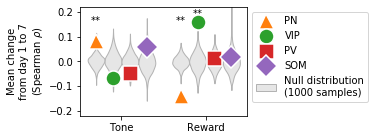

In [9]:
# Plot null distributions as violins
null_arr = np.array([
    bootstrap_dfs[ct].query('(trial_component == @tr_component) and (day == "delta")')['spearman']
    for tr_component, ct in itertools.product(['tone + delay', 'reward'], ['pyr', 'vip', 'pv', 'som'])
]).T
x_positions = [-0.5, 0, 0.5, 1, 2, 2.5, 3, 3.5]

plt.figure(figsize=(3, 2))
plt.subplot(111)
violins = plt.violinplot(null_arr, x_positions, showextrema=False)

for i, violin in enumerate(violins['bodies']):
    violin.set_edgecolor((0.7,) * 3)
    violin.set_facecolor((0.9,) * 3)
    violin.set_alpha(1)
    if i == 0:
        violin.set_label('Null distribution\n(1000 samples)')

# Plot observed values
y_obs = [
    get_change(obs_df, ct).groupby('mouse_id').mean()[tr_component].mean()
    for tr_component, ct in itertools.product(['tone + delay', 'reward'], ['pyr', 'vip', 'pv', 'som'])
]
labels = ['PN', 'VIP', 'PV', 'SOM']  # Labels for the x-axis. Make sure they match the order in y_obs above.
shapes = ['^', 'o', 's', 'D']      # Shapes for the markers. See matplotlib.markers for more.
for i, (x_pos, y) in enumerate(zip(x_positions, y_obs)):
    pt = plt.plot(
        x_pos, y, shapes[i%4], 
        color=sns.color_palette()[i%4+1], markersize=15, markeredgecolor='w', mew=1.5
    )
    if i < 4:
        # Only attach legend labels once. Removing this line will cause duplicate entries in legend.
        pt[0].set_label(labels[i])

# Add statistical annotations
for i, x_pos in enumerate(x_positions):
    print(f'F(y_{i}) = {(y_obs[i] < null_arr[:, i]).sum() / null_arr.shape[0]} (x_pos = {x_pos}; min. p is {1/null_arr.shape[0]})')
    for stat_thresh in [0.01, 0.05]:
        if (
            y_obs[i] < np.percentile(null_arr[:, i], 100 * stat_thresh/2.)  # Below ower tail of null dist
        ) or (
            y_obs[i] > np.percentile(null_arr[:, i], 100 * (1-stat_thresh/2.))  # Above upper tail of null dist
        ):
            plt.annotate(
                stat_thresholds[stat_thresh], 
                (x_pos, max(0.15, y_obs[i] + 0.02)), 
                ha='center'
            )
            break

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.xticks([0.25, 2.75], ['Tone', 'Reward'])
plt.ylim(-0.22, 0.22)
plt.ylabel('Mean change\nfrom day 1 to 7\n(Spearman $\\rho$)')

plt.savefig(f'../img/bootstrap/all_celltypes_change_corr.png', dpi=600, bbox_inches='tight')
plt.savefig(f'../img/bootstrap/all_celltypes_change_corr.svg', bbox_inches='tight')

plt.show()

In [ ]:
print(f'Min. p-value is {})